In [1]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import model_selection, preprocessing
import seaborn as sns
from scipy import stats

In [2]:
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')

In [3]:
#loan id doesn't matter so drop it
def clean_LoanID(dataset):
    dataset = dataset.drop(columns = 'Loan_ID')
    print(dataset.head())

    return dataset

train_df = clean_LoanID(train_df)
print()
test_df = clean_LoanID(test_df)

Gender Married Dependents     Education Self_Employed  ApplicantIncome  \
0   Male      No          0      Graduate            No             5849   
1   Male     Yes          1      Graduate            No             4583   
2   Male     Yes          0      Graduate           Yes             3000   
3   Male     Yes          0  Not Graduate            No             2583   
4   Male      No          0      Graduate            No             6000   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0                0.0         NaN             360.0             1.0   
1             1508.0       128.0             360.0             1.0   
2                0.0        66.0             360.0             1.0   
3             2358.0       120.0             360.0             1.0   
4                0.0       141.0             360.0             1.0   

  Property_Area Loan_Status  
0         Urban           Y  
1         Rural           N  
2         Urban           Y  
3   

In [4]:
def clean_married(dataset):
    print(dataset['Married'].isna().sum())
    dataset['Married'].fillna(dataset['Married'].mode()[0], inplace = True)
    print(dataset['Married'].isna().sum())

    return dataset

train_df = clean_married(train_df)
print()
test_df = clean_married(test_df)


3
0

0
0


In [5]:
#replcae Nan values mode of Gender feature
def clean_gender(dataset):
    print(dataset['Gender'].isna().sum())
    inplace = dataset['Gender'].mode()[0]
    print(inplace)
    dataset['Gender'].fillna(inplace, inplace=True)
    print(dataset['Gender'].isna().sum())
    #print(dataset['Gender'].isna().sum())

    return dataset

train_df = clean_gender(train_df)
test_df = clean_gender(test_df)

13
Male
0
11
Male
0


In [6]:
#replace '3+' with 3 in Dependents featrue
def clean_dependents(dataset):

    dataset['Dependents'] = dataset['Dependents'].replace('3+', 3)
    print(dataset['Dependents'].loc[[7,8]])
    print(dataset['Dependents'].loc[[104, 105, 106]])
    print()
    #replace Nan values with mode of Dependents feature
    dataset['Dependents'].fillna(dataset['Dependents'].mode()[0], inplace = True)

    print(dataset['Dependents'].loc[[104, 105, 106]])

    return dataset

train_df = clean_dependents(train_df)
test_df = clean_dependents(test_df)


7    3
8    2
Name: Dependents, dtype: object
104    NaN
105      1
106      2
Name: Dependents, dtype: object

104    0
105    1
106    2
Name: Dependents, dtype: object
7    2
8    2
Name: Dependents, dtype: object
104    0
105    0
106    0
Name: Dependents, dtype: object

104    0
105    0
106    0
Name: Dependents, dtype: object


In [7]:
def clean_education(dataset):
    print(dataset['Education'].isna().sum())
    dataset['Education'].fillna(dataset['Education'].mode()[0], inplace = True)
    print(dataset['Education'])
    return dataset


train_df = clean_education(train_df)
test_df = clean_education(test_df)


0
0          Graduate
1          Graduate
2          Graduate
3      Not Graduate
4          Graduate
           ...     
609        Graduate
610        Graduate
611        Graduate
612        Graduate
613        Graduate
Name: Education, Length: 614, dtype: object
0
0          Graduate
1          Graduate
2          Graduate
3          Graduate
4      Not Graduate
           ...     
362    Not Graduate
363        Graduate
364        Graduate
365        Graduate
366        Graduate
Name: Education, Length: 367, dtype: object


In [8]:
def clean_self_employed(dataset):
    print(dataset['Self_Employed'].isna().sum())
    dataset['Self_Employed'].fillna(dataset['Self_Employed'].mode()[0], inplace = True)
    print(dataset['Self_Employed'].isna().sum())

    return dataset



train_df = clean_self_employed(train_df)
test_df = clean_self_employed(test_df)

32
0
23
0


(614, 12)
0      0.072991
1      0.134412
2      0.393747
3      0.462062
4      0.097728
         ...   
609    0.410130
610    0.212557
611    0.437174
612    0.357064
613    0.134412
Name: ApplicantIncome, Length: 614, dtype: float64
0.29475926026046173
<bound method NDFrame.head of 0      0.072991
1      0.134412
2      0.393747
3      0.462062
4      0.097728
         ...   
609    0.410130
610    0.212557
611    0.437174
612    0.357064
613    0.134412
Name: ApplicantIncome, Length: 570, dtype: float64>
(570, 12)


(367, 11)
0      0.186461
1      0.352692
2      0.039641
3      0.502774
4      0.311909
         ...   
362    0.162439
363    0.132056
364    0.317211
365    0.039641
366    0.896087
Name: ApplicantIncome, Length: 367, dtype: float64
0.34390360060556413
<bound method NDFrame.head of 0      0.186461
1      0.352692
2      0.039641
3      0.502774
4      0.311909
         ...   
362    0.162439
363    0.132056
364    0.317211
365    0.039641
366    0.896087
Name: Appl

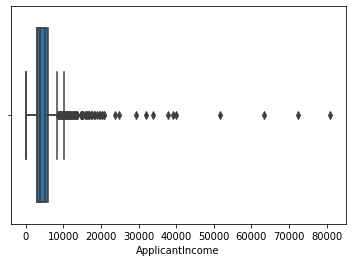

In [9]:
def clean_income(dataset):
    print(dataset.shape)
    sns.boxplot(x=dataset['ApplicantIncome'])
    dataset['ApplicantIncome'] = np.abs(stats.zscore(dataset['ApplicantIncome']))
    print(dataset['ApplicantIncome'])
    Q1 = dataset['ApplicantIncome'].quantile(0.25)
    Q3 = dataset['ApplicantIncome'].quantile(0.75)
    IQR = Q3 - Q1
    minv = (Q1 - 1.5 * IQR)
    maxv = (Q3 + 1.5 * IQR)
    print(IQR) 
    #remove rows that are of iqr
    dataset = dataset[dataset['ApplicantIncome'] > minv]
    dataset = dataset[dataset['ApplicantIncome'] < maxv]
    print(dataset['ApplicantIncome'].head)
    print(dataset.shape)
    print()

    return dataset

    


train_df = clean_income(train_df)
print()
test_df = clean_income(test_df)

In [10]:
def clean_coapp(dataset):

    dataset['CoapplicantIncome'].fillna(0, inplace = True)
    print(dataset.head)

    return dataset

train_df = clean_coapp(train_df)
test_df = clean_coapp(test_df)

<bound method NDFrame.head of      Gender Married Dependents     Education Self_Employed  ApplicantIncome  \
0      Male      No          0      Graduate            No         0.072991   
1      Male     Yes          1      Graduate            No         0.134412   
2      Male     Yes          0      Graduate           Yes         0.393747   
3      Male     Yes          0  Not Graduate            No         0.462062   
4      Male      No          0      Graduate            No         0.097728   
..      ...     ...        ...           ...           ...              ...   
609  Female      No          0      Graduate            No         0.410130   
610    Male     Yes          3      Graduate            No         0.212557   
611    Male     Yes          1      Graduate            No         0.437174   
612    Male     Yes          2      Graduate            No         0.357064   
613  Female      No          0      Graduate           Yes         0.134412   

     CoapplicantIncom

In [11]:
def clean_property(dataset):
    print(dataset['Property_Area'].isna().sum())
    dataset['Property_Area'].fillna(dataset['Self_Employed'].mode()[0], inplace = True)
    print(dataset['Property_Area'].isna().sum())


    return dataset

train_df = clean_property(train_df)
test_df = clean_property(test_df)

0
0
0
0


In [13]:
def clean_credit(dataset):
    print(dataset['Credit_History'].isna().sum())
    dataset['Credit_History'].fillna(dataset['Self_Employed'].mode()[0], inplace = True)
    print(dataset['Credit_History'].isna().sum())
    

    return dataset

train_df = clean_credit(train_df)
test_df = clean_credit(test_df)

47
0
27
0


In [28]:
y_train = train_df['Loan_Status']
X = train_df.drop(columns='Loan_Status')


In [30]:
X_test = test_df

In [31]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y_train)

ValueError: could not convert string to float: 'Male'